## 12.アソシエーション分析

In [ ]:
import pandas as pd
import numpy as np

### 前処理

データを読み込みます。  
参考URLの記事を書いている方の書籍のデータセットを使用しています。

In [ ]:
df = pd.read_csv("association.csv", index_col=0)
df.head()

,PurchaseDate,Item,Amount,Number
CustomerCD,,,,
Customer0000208,2019/10/12,Macaroons,530,2
Customer0000422,2019/11/22,Macaroons,530,1
Customer0000422,2020/5/19,Macaroons,530,2
Customer0000675,2019/11/6,Macaroons,530,3
Customer0000675,2019/10/8,Rare cheesecake,380,3


ここからデータを加工していきます。

In [ ]:
# Customer CDとItemをキーに商品個数を集計する
w1 = df.groupby(['CustomerCD', 'Item'])['Number'].sum()

w1.head()

CustomerCD       Item           
Customer0000001  Chocolate cake      8
                 Financier           2
                 Gateau chocolat     4
                 Macaroons           8
                 Pudding            12
Name: Number, dtype: int64

In [ ]:
# 商品番号を列に移動 (unstack関数の利用)
w2 = w1.unstack().reset_index().fillna(0).set_index('CustomerCD')

w2.head()

Item,Apple Pie,Chocolate cake,Eclair,Financier,Gateau chocolat,Macaroons,Pudding,Rare cheesecake,Shortcake,cookie,cream puff,jelly
CustomerCD,,,,,,,,,,,,
Customer0000001,0.0,8.0,0.0,2.0,4.0,8.0,12.0,3.0,40.0,0.0,0.0,4.0
Customer0000003,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,0.0,0.0
Customer0000005,0.0,1.0,2.0,0.0,0.0,9.0,12.0,1.0,73.0,0.0,5.0,10.0
Customer0000009,0.0,6.0,0.0,0.0,3.0,5.0,0.0,5.0,31.0,0.0,2.0,0.0
Customer0000015,20.0,13.0,6.0,14.0,8.0,1.0,3.0,0.0,61.0,0.0,3.0,0.0


In [ ]:
# 集計結果が正の場合True、0の場合Falseとする
basket_df = w2.apply(lambda x: x>0)

basket_df.head()

Item,Apple Pie,Chocolate cake,Eclair,Financier,Gateau chocolat,Macaroons,Pudding,Rare cheesecake,Shortcake,cookie,cream puff,jelly
CustomerCD,,,,,,,,,,,,
Customer0000001,False,True,False,True,True,True,True,True,True,False,False,True
Customer0000003,False,False,True,False,False,True,False,False,True,False,False,False
Customer0000005,False,True,True,False,False,True,True,True,True,False,True,True
Customer0000009,False,True,False,False,True,True,False,True,True,False,True,False
Customer0000015,True,True,True,True,True,True,True,False,True,False,True,False


### モデル構築

アプリオリ分析という手法で、Support（支持度）を求め、Supportの値が高いリストを抽出します。

In [ ]:
# ライブラリの読み込み
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# アプリオリによる分析
freq_items1 = apriori(basket_df, min_support = 0.06, use_colnames = True)

# Supportが高い順に表示
freq_items1.sort_values('support', ascending = False).head()

,support,itemsets
8,0.839688,(Shortcake)
6,0.269637,(Pudding)
1,0.241617,(Chocolate cake)
18,0.206247,"(Pudding, Shortcake)"
0,0.188792,(Apple Pie)


Confidence（信頼度）やLift（リフト）を求めます。リフトは、Support（支持度）が、あまり売れていない商品をどう扱うかのための指標であったのと逆に、売れ筋商品をどう扱うかという指標です。  

今回は、リフト値が高い関係を抽出しています。

In [ ]:
# アソシエーションルールの抽出
a_rules1 = association_rules(freq_items1, metric = "lift", min_threshold = 1)

# リフト値が高い順にソート
a_rules1 = a_rules1.sort_values('lift', ascending = False).reset_index(drop=True)

a_rules1.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Chocolate cake),(Apple Pie),0.241617,0.188792,0.091870,0.380228,2.014006,0.046254,1.308882
1,(Apple Pie),(Chocolate cake),0.188792,0.241617,0.091870,0.486618,2.014006,0.046254,1.477230
2,"(Chocolate cake, Shortcake)",(Apple Pie),0.186495,0.188792,0.069821,0.374384,1.983052,0.034612,1.296655
3,(Apple Pie),"(Chocolate cake, Shortcake)",0.188792,0.186495,0.069821,0.369830,1.983052,0.034612,1.290929
4,(Chocolate cake),"(Apple Pie, Shortcake)",0.241617,0.162150,0.069821,0.288973,1.782139,0.030643,1.178367


### networkxで可視化

NetworkXを使って、関係グラフを作ることもできます。

In [ ]:
import networkx as nx

#抽出したリストからantecedentsとconsequentsのみをピックアップ
edges = a_rules1[['antecedents', 'consequents']].values
edges

array([[frozenset({'Chocolate cake'}), frozenset({'Apple Pie'})],
       [frozenset({'Apple Pie'}), frozenset({'Chocolate cake'})],
       [frozenset({'Chocolate cake', 'Shortcake'}),
        frozenset({'Apple Pie'})],
       [frozenset({'Apple Pie'}),
        frozenset({'Chocolate cake', 'Shortcake'})],
       [frozenset({'Chocolate cake'}),
        frozenset({'Apple Pie', 'Shortcake'})],
       [frozenset({'Apple Pie', 'Shortcake'}),
        frozenset({'Chocolate cake'})],
       [frozenset({'Eclair'}), frozenset({'Shortcake'})],
       [frozenset({'Shortcake'}), frozenset({'Eclair'})],
       [frozenset({'Shortcake'}), frozenset({'Rare cheesecake'})],
       [frozenset({'Rare cheesecake'}), frozenset({'Shortcake'})],
       [frozenset({'Shortcake'}), frozenset({'Macaroons'})],
       [frozenset({'Macaroons'}), frozenset({'Shortcake'})],
       [frozenset({'cream puff'}), frozenset({'Shortcake'})],
       [frozenset({'Shortcake'}), frozenset({'cream puff'})],
       [frozenset({'jell

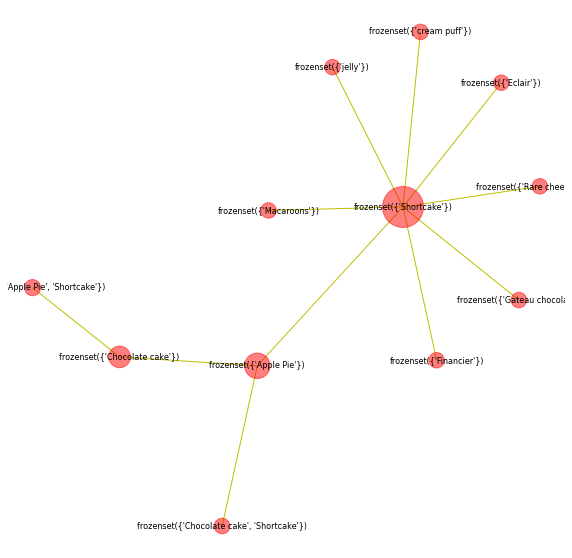

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

#抽出したリストからantecedentsとconsequentsのみをピックアップ
edges = a_rules1[['antecedents', 'consequents']].values

G = nx.from_edgelist(edges)
 
plt.figure(figsize=(10, 10))
 
pos = nx.spring_layout(G, k=0.7)
 
#PageRankの追加
pr = nx.pagerank(G)
 
nx.draw_networkx_edges(G, pos, edge_color='y')
 
#node_sizeにPageRankの値を組み込む
nx.draw_networkx_nodes(G, pos, node_color='r', alpha=0.5, node_size=[5000*v for v in pr.values()])
nx.draw_networkx_labels(G, pos, font_size=8)
 
plt.axis('off')
plt.show()